In [1]:
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
floors=20
N=100
lifts=4
length=10
def rand(orders,a,floors=floors):
    b=orders[random.randint(0, len(orders)-1)]
    while a==b:
        b=orders[random.randint(0, len(orders)-1)]
    return b
def sequences_generator(orders,lifts=lifts,floors=floors,length=length):
    pattern=np.zeros((len(orders)**3,lifts,length+1),dtype="int")
    for i in range(len(orders)**3):
        for k in range(lifts):
            pattern[i][k][0]=orders[random.randint(0, len(orders)-1)]
            for j in range(1,length+1):
                pattern[i][k][j]=rand(orders,pattern[i][k][j-1])
    return pattern

In [2]:
speed = 3
load_time = 15

class Elevator(object):
    def __init__(self, init_pos, max_occ):
        self.pos = init_pos
        self.status = 2
        self.progress = 0
        self.stops = []
        
        self.cur_occ = 0
        self.cur_pas = set([])
        self.max_occ = max_occ
        self.loading = False
        
    def reschedule(self, stops):
        old_status = self.status
        old_progress = self.progress
        
        if old_status==2:
            self.stops = stops
            if self.pos==self.stops[0]:
                self.stops.pop(0)
                self.status = 0
                self.progress = 0
            else:
                self.status = (-1)**(self.pos>self.stops[0])
                self.progress = 0
        
        elif old_status==0:
            self.stops = stops
            if self.pos==self.stops[0]:
                self.stops.pop(0)
            
        elif old_status==1:
            abs_pos = self.abs_pos()
            if abs_pos==speed*stops[0]:
                stops.pop(0)
                self.status = 0
                self.progress = 0
                
                self.stops = stops
            elif abs_pos<speed*stops[0]:
                self.stops = stops
            else:
                self.status = -1
                self.progress = (-self.progress)%3
                self.pos = self.pos+1 if self.progress>0 else self.pos
                
                self.stops = stops
                
        elif old_status == -1:
            abs_pos = self.abs_pos()
            if abs_pos==speed*stops[0]:
                stops.pop(0)
                self.status = 0
                self.progress = 0
                
                self.stops = stops
            elif abs_pos>speed*stops[0]:
                self.stops = stops
            else:
                self.status = 1
                self.progress = (-self.progress)%3
                self.pos = self.pos-1 if self.progress>0 else self.pos
                
                self.stops = stops
        
    def act(self):
        if self.status == 1:
            self.move_up()
        elif self.status == -1:
            self.move_down()
        elif self.status == 0:
            self.stop()
        elif len(self.stops)>0:
#             self.cur_dir = (-1)**(self.pos>self.stops[0])
#             self.status = self.cur_dir 
            self.status = (-1)**(self.pos>self.stops[0])
            
    def move_up(self):
        self.progress += 1
        if self.progress == speed:
            self.progress = 0
            self.pos += 1
            
            if self.pos==self.stops[0]:
                self.status = 0
#                 self.cur_dir = (-1)**(self.pos>self.stops[1]) if len(self.stops)>1 else 0
                self.stops.pop(0)
    
    def move_down(self):
        self.progress += 1
        if self.progress == speed:
            self.progress = 0
            self.pos -= 1
            
            if self.pos==self.stops[0]:
                self.status = 0
#                 self.cur_dir = (-1)**(self.pos>self.stops[1]) if len(self.stops)>1 else 0
                self.stops.pop(0)
            
    def stop(self):
        if self.progress==0:
            self.loading = True
            
        self.progress += 1
        if self.progress == load_time:
            self.progress = 0
            self.loading = False
            
            if len(self.stops)>0:
                self.status = (-1)**(self.pos>self.stops[0])
            else:
                self.status = 2
#                 self.cur_dir == 0
    
    def load(self, upload, download):
        self.cur_pas = self.cur_pas - upload
        self.cur_pas = self.cur_pas.union(download)
        self.cur_occ = len(self.cur_pas)
#         self.loading = False
        
        if self.cur_occ>self.max_occ:
            print("Overload!!!")
        
    def abs_pos(self):
        return self.status*self.progress+speed*self.pos
    
max_occ = 6       

In [3]:
class Building1(object):
    def __init__(self, n_floors, n_elevs, pass_arr, order):
        self.n_floors = n_floors
        self.n_elevs = n_elevs
        self.time = 0
        
        self.elevators = [Elevator(n_floors-1, max_occ) for i in range(n_elevs)]
        self.floor_pas = [set([]) for i in range(n_floors)]
        
        self.pass_arr = copy.deepcopy(pass_arr)
        self.order = copy.deepcopy(order)
            
    def load(self):
        for elev in self.elevators:
            if elev.loading:
                floor = elev.pos
                upload = set([pas for pas in elev.cur_pas if self.pass_arr[pas][2]==floor])
                download = set([pas for pas in self.floor_pas[floor] if self.pass_arr[pas][2] in elev.stops])
                
                max_download = max_occ-(elev.cur_occ-len(upload))
                if len(download)>max_download:
                    download = set(sorted(list(download))[:max_download])
                    elev.loading = False
                    
                elev.load(upload, download)
                
                self.floor_pas[floor] = self.floor_pas[floor]-download
                
                for pas in download:
                    self.pass_arr[pas].append(self.time)
                
                for pas in upload:
                    self.pass_arr[pas].append(self.time)
    
    def reschedule(self, stops):
        for i in range(self.n_elevs):
            if stops[i] is not None:
                self.elevators[i].reschedule(stops[i])
                
    def elev_act(self):
        for elev in self.elevators:
            elev.act()
            
    def copyfrom(self, floor_pas, elevators, time):
        for i in range(self.n_elevs):
            self.elevators[i] = copy.deepcopy(elevators[i])
        self.floor_pas = copy.deepcopy(floor_pas)
        self.time = time
    
    def act(self, n_secs):
        self.reschedule(self.order)
        for i in range(n_secs):
            self.load()

            self.elev_act()
            
            self.time += 1
            
        return self.pass_arr
            
    

In [4]:
class Building(object):
    def __init__(self, n_floors, n_elevs, pass_arr):
        self.n_floors = n_floors
        self.n_elevs = n_elevs
        self.time = 0
        
        self.elevators = [Elevator(n_floors-1, max_occ) for i in range(n_elevs)]
        self.floor_pas = [set([]) for i in range(n_floors)]
        
        self.pass_arr = pass_arr
        self.result = []
        self.total_pas = len(pass_arr)
        self.last_id = 0
        
    def check_new_pas(self):
        prev = self.last_id
        while self.last_id<self.total_pas and (self.time>=self.pass_arr[self.last_id][0]):
            self.floor_pas[self.pass_arr[self.last_id][1]].add(self.last_id)
            self.last_id += 1
            
            
        return prev!=self.last_id
            
    def load(self):
        for elev in self.elevators:
            if elev.loading:
                floor = elev.pos
                upload = set([pas for pas in elev.cur_pas if self.pass_arr[pas][2]==floor])
                download = set([pas for pas in self.floor_pas[floor] if self.pass_arr[pas][2] in elev.stops])
                
                max_download = max_occ-(elev.cur_occ-len(upload))
                if len(download)>max_download:
                    download = set(sorted(list(download))[:max_download])
                    elev.loading = False
                    
                elev.load(upload, download)
                
                self.floor_pas[floor] = self.floor_pas[floor]-download
                
                for pas in download:
                    self.pass_arr[pas].append(self.time)
                
                for pas in upload:
                    self.pass_arr[pas].append(self.time)
    
    def reschedule(self, stops):
        for i in range(self.n_elevs):
            if stops[i] is not None:
                self.elevators[i].reschedule(stops[i])
                
    def elev_act(self):
        for elev in self.elevators:
            elev.act()
                
    def get_meta(self):
        elev_pas = [elev.cur_pas for elev in self.elevators]
        elev_stat = [elev.status for elev in self.elevators]
        elev_abs_pos = [elev.abs_pos() for elev in self.elevators]
        
        return self.floor_pas, elev_pas, elev_abs_pos, elev_stat
    
    def act(self, n_secs):
        for i in range(n_secs):
            is_changed = self.check_new_pas()
            
            meta = self.get_meta()
            
            if is_changed:
                new_stops = self.brains(meta)
                
                self.reschedule(new_stops)
                
            self.load()
                
            self.elev_act()
            
            self.time += 1
            
    def brains(self, meta):
        floor_pass,elef_pass,elef_abs_pos,elef_stat=meta
        orders=[]
        print("time",self.time)
        floor_pas_id = [pas for floor in floor_pass for pas in floor]
        for pas in floor_pas_id:
            orders.append(self.pass_arr[pas][1])
            orders.append(self.pass_arr[pas][2])
        elef_pas_id = [pas for elef in elef_pass for pas in elef]
        for pas in elef_pas_id:
            orders.append(self.pass_arr[pas][2])
            
        all_pas_id = sorted(floor_pas_id+elef_pas_id)
        new_pass_arr = {pas:self.pass_arr[pas] for pas in all_pas_id}
        print(str(len(all_pas_id))+"&", orders)
        sequence=sequences_generator(orders)
        
        people=sum([elev.cur_occ for elev in self.elevators])+sum([len(floor) for floor in self.floor_pas])
        waiting_time=1000000
        
        for np_order in sequence:
            order = [list(e) for e in np_order]
            virt_bld = Building1(self.n_floors, self.n_elevs, new_pass_arr, order)
            virt_bld.copyfrom(self.floor_pas, self.elevators, self.time)
            result = virt_bld.act(500)
            if all([len(result[i])==5 for i in all_pas_id]) and sum([result[i][4]-result[i][0] for i in all_pas_id])<waiting_time:
                waiting_time=sum([result[i][4]-result[i][0] for i in all_pas_id])
                print(waiting_time/len(all_pas_id))
                best_order = copy.deepcopy(order)
        return best_order

In [5]:
pass_array=np.array([])
f=open('real.txt', 'r')
pass_array = []
for line in f:
    pass_array.append([int(e) for e in line.strip().split()])
f.close()

In [6]:
bld=Building(n_floors=floors+1, n_elevs=lifts, pass_arr=pass_array)
bld.act(60000)
bld.pass_arr

time 133
2& [0, 17, 0, 17]
127.0
time 330
2& [0, 10, 0, 10]
41.0
time 332
3& [15, 20, 10, 10]
125.0
65.0
55.333333333333336
55.0
50.0
time 582
1& [0, 6]
81.0
77.0
76.0
66.0
time 626
3& [4, 17, 4, 17, 6]
111.33333333333333
75.33333333333333
69.33333333333333
time 707
1& [13, 4]
46.0
time 761
1& [12, 0]
63.0
time 763
2& [0, 17, 12, 0]
175.0
80.0
70.5
time 881
1& [3, 19]
67.0
time 894
5& [0, 7, 0, 7, 0, 7, 0, 7, 19]
82.0
67.6
64.6
63.8
time 922
7& [0, 11, 0, 11, 19, 7, 7, 7, 7]
152.57142857142858
72.0
68.57142857142857
67.42857142857143
63.857142857142854
63.57142857142857
61.714285714285715
time 1055
1& [0, 20]
103.0
time 1060
2& [0, 20, 0, 8]
140.5
126.0
109.0
90.0
time 1073
4& [0, 20, 0, 8, 0, 6, 0, 6]
178.25
118.5
84.5
74.0
71.25
time 1200
1& [17, 11]
38.0
time 1324
1& [2, 14]
85.0
time 1331
2& [2, 14, 16, 20]
128.0
57.5
time 1412
2& [0, 14, 0, 14]
67.0
time 1567
2& [0, 1, 0, 1]
31.0
20.0
time 1711
1& [0, 14]
49.0
time 2010
3& [15, 2, 15, 2, 15, 2]
73.0
61.0
60.0
time 2078
2& [2, 0, 2

time 28936
1& [13, 0]
69.0
time 29214
1& [11, 0]
61.0
51.0
time 29321
1& [12, 0]
56.0
time 29344
2& [17, 0, 0]
74.5
69.5
time 29413
3& [17, 0, 17, 0, 0]
128.0
121.0
111.33333333333333
81.0
time 29575
1& [14, 10]
35.0
time 29591
2& [20, 0, 10]
183.0
136.0
106.0
61.0
time 29701
1& [16, 6]
54.0
time 29708
2& [13, 10, 16, 6]
133.0
116.0
79.5
67.0
55.0
time 29715
3& [7, 0, 13, 10, 16, 6]
100.0
81.0
61.0
time 29725
4& [9, 18, 16, 6, 10, 0]
189.75
179.5
155.0
138.0
135.5
112.0
108.0
101.0
95.75
94.5
88.25
time 29824
2& [18, 0, 18]
141.0
103.5
time 29853
4& [8, 0, 8, 0, 0, 18]
88.0
75.75
time 29880
4& [8, 17, 0, 0, 0]
69.5
58.5
53.75
time 29914
2& [1, 0, 17]
155.5
148.0
138.5
137.5
87.0
82.0
31.5
time 29922
4& [2, 0, 2, 0, 2, 0, 0]
29.0
23.0
time 30109
2& [5, 8, 5, 8]
37.0
time 30389
1& [16, 20]
61.0
time 30451
1& [16, 0]
89.0
time 30598
1& [7, 2]
99.0
54.0
time 30629
2& [16, 0, 2]
160.0
97.0
95.5
84.0
76.0
time 30656
2& [4, 0, 16, 0]
138.5
137.5
82.0
68.5
68.0
time 30842
2& [2, 14, 2, 14]
93.

time 45411
1& [16, 0]
83.0
time 45416
2& [9, 14, 16, 0]
141.5
139.0
71.0
62.5
time 45441
3& [0, 17, 0, 14]
110.0
74.66666666666667
72.66666666666667
67.66666666666667
time 45444
5& [0, 17, 0, 19, 0, 19, 0, 14]
244.0
243.4
128.8
97.4
94.6
85.6
85.0
82.4
time 45469
5& [0, 17, 0, 14, 19, 19, 0]
205.8
118.8
116.4
103.8
84.6
time 45506
5& [19, 5, 19, 19, 17, 14]
100.4
94.6
91.4
86.0
time 45575
2& [0, 7, 5]
112.0
89.5
74.5
time 45577
3& [0, 7, 0, 10, 5]
156.66666666666666
136.33333333333334
121.33333333333333
117.33333333333333
115.66666666666667
100.33333333333333
91.33333333333333
87.33333333333333
81.33333333333333
time 45612
3& [0, 7, 0, 10, 19, 2]
237.0
111.0
109.66666666666667
105.0
92.0
time 45739
2& [0, 14, 0, 14]
111.0
66.0
time 45774
3& [13, 19, 14, 14]
109.33333333333333
65.0
62.333333333333336
58.666666666666664
time 45777
4& [8, 3, 13, 19, 14, 14]
104.75
73.5
61.0
time 45864
1& [0, 1]
53.0
38.0
time 45993
1& [20, 10]
104.0
time 46212
5& [0, 17, 0, 17, 0, 17, 0, 17, 2, 7]
177.4
9

time 57434
3& [15, 0, 16, 0, 20, 13]
246.0
191.66666666666666
154.33333333333334
125.0
116.66666666666667
101.66666666666667
100.66666666666667
100.33333333333333
87.33333333333333


[[133, 0, 17, 194, 260],
 [133, 0, 17, 194, 260],
 [330, 0, 10, 330, 371],
 [330, 0, 10, 330, 371],
 [332, 15, 20, 370, 400],
 [582, 0, 6, 615, 648],
 [626, 4, 17, 643, 697],
 [626, 4, 17, 643, 697],
 [707, 13, 4, 711, 753],
 [761, 12, 0, 773, 824],
 [763, 0, 17, 775, 841],
 [881, 3, 19, 885, 1011],
 [894, 0, 7, 909, 945],
 [894, 0, 7, 909, 945],
 [894, 0, 7, 909, 945],
 [894, 0, 7, 909, 945],
 [922, 0, 11, 922, 972],
 [922, 0, 11, 922, 970],
 [1055, 0, 20, 1083, 1173],
 [1060, 0, 8, 1102, 1141],
 [1073, 0, 6, 1083, 1116],
 [1073, 0, 6, 1083, 1116],
 [1200, 17, 11, 1205, 1238],
 [1324, 2, 14, 1358, 1409],
 [1331, 16, 20, 1334, 1361],
 [1412, 0, 14, 1422, 1479],
 [1412, 0, 14, 1422, 1479],
 [1567, 0, 1, 1569, 1587],
 [1567, 0, 1, 1569, 1587],
 [1711, 0, 14, 1711, 1760],
 [2010, 15, 2, 2016, 2070],
 [2010, 15, 2, 2016, 2070],
 [2010, 15, 2, 2016, 2070],
 [2078, 2, 0, 2078, 2091],
 [2078, 2, 0, 2078, 2091],
 [2264, 15, 0, 2305, 2365],
 [2279, 0, 12, 2279, 2324],
 [2364, 0, 5, 2365, 2395],

In [7]:
log=copy.deepcopy(bld.pass_arr)
for i in range(4):
    print(bld.elevators[i].cur_pas)

set()
set()
set()
set()


In [8]:
log    

[[133, 0, 17, 194, 260],
 [133, 0, 17, 194, 260],
 [330, 0, 10, 330, 371],
 [330, 0, 10, 330, 371],
 [332, 15, 20, 370, 400],
 [582, 0, 6, 615, 648],
 [626, 4, 17, 643, 697],
 [626, 4, 17, 643, 697],
 [707, 13, 4, 711, 753],
 [761, 12, 0, 773, 824],
 [763, 0, 17, 775, 841],
 [881, 3, 19, 885, 1011],
 [894, 0, 7, 909, 945],
 [894, 0, 7, 909, 945],
 [894, 0, 7, 909, 945],
 [894, 0, 7, 909, 945],
 [922, 0, 11, 922, 972],
 [922, 0, 11, 922, 970],
 [1055, 0, 20, 1083, 1173],
 [1060, 0, 8, 1102, 1141],
 [1073, 0, 6, 1083, 1116],
 [1073, 0, 6, 1083, 1116],
 [1200, 17, 11, 1205, 1238],
 [1324, 2, 14, 1358, 1409],
 [1331, 16, 20, 1334, 1361],
 [1412, 0, 14, 1422, 1479],
 [1412, 0, 14, 1422, 1479],
 [1567, 0, 1, 1569, 1587],
 [1567, 0, 1, 1569, 1587],
 [1711, 0, 14, 1711, 1760],
 [2010, 15, 2, 2016, 2070],
 [2010, 15, 2, 2016, 2070],
 [2010, 15, 2, 2016, 2070],
 [2078, 2, 0, 2078, 2091],
 [2078, 2, 0, 2078, 2091],
 [2264, 15, 0, 2305, 2365],
 [2279, 0, 12, 2279, 2324],
 [2364, 0, 5, 2365, 2395],

In [9]:
delivered=list(filter(lambda x: len(x)==5, log))
delivered

[[133, 0, 17, 194, 260],
 [133, 0, 17, 194, 260],
 [330, 0, 10, 330, 371],
 [330, 0, 10, 330, 371],
 [332, 15, 20, 370, 400],
 [582, 0, 6, 615, 648],
 [626, 4, 17, 643, 697],
 [626, 4, 17, 643, 697],
 [707, 13, 4, 711, 753],
 [761, 12, 0, 773, 824],
 [763, 0, 17, 775, 841],
 [881, 3, 19, 885, 1011],
 [894, 0, 7, 909, 945],
 [894, 0, 7, 909, 945],
 [894, 0, 7, 909, 945],
 [894, 0, 7, 909, 945],
 [922, 0, 11, 922, 972],
 [922, 0, 11, 922, 970],
 [1055, 0, 20, 1083, 1173],
 [1060, 0, 8, 1102, 1141],
 [1073, 0, 6, 1083, 1116],
 [1073, 0, 6, 1083, 1116],
 [1200, 17, 11, 1205, 1238],
 [1324, 2, 14, 1358, 1409],
 [1331, 16, 20, 1334, 1361],
 [1412, 0, 14, 1422, 1479],
 [1412, 0, 14, 1422, 1479],
 [1567, 0, 1, 1569, 1587],
 [1567, 0, 1, 1569, 1587],
 [1711, 0, 14, 1711, 1760],
 [2010, 15, 2, 2016, 2070],
 [2010, 15, 2, 2016, 2070],
 [2010, 15, 2, 2016, 2070],
 [2078, 2, 0, 2078, 2091],
 [2078, 2, 0, 2078, 2091],
 [2264, 15, 0, 2305, 2365],
 [2279, 0, 12, 2279, 2324],
 [2364, 0, 5, 2365, 2395],

In [10]:
f = open('delivered_smart1.txt', 'w')
for call in delivered:
    for symbol in call:
        f.write(str(symbol)+"\t")
    f.write("\n")
f.close()

In [11]:
wait_mean=np.array([delivered[i][3]-delivered[i][0] for i in range(len(delivered))]).mean()
print("wait_mean",wait_mean)
going_mean=np.array([delivered[i][4]-delivered[i][3] for i in range(len(delivered))]).mean()
print("going_mean",going_mean)
total_mean=np.array([delivered[i][4]-delivered[i][0] for i in range(len(delivered))]).mean()
print("total_mean",total_mean)

wait_mean 15.758526603001364
going_mean 43.79945429740791
total_mean 59.55798090040928


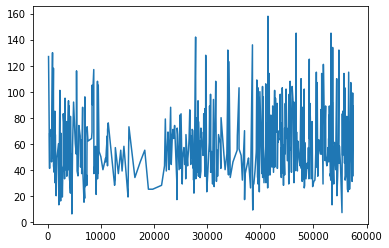

In [12]:
x_axis = sorted(list(set(np.array(delivered).T[0])))
y_axis = {}
for x in x_axis:
    y = list(filter(lambda e: e[0]==x, delivered))
    y = [e[4]-e[0] for e in y]
    y_axis[x] = sum(y)/len(y)

y_axis = [y_axis[x] for x in x_axis]
plt.plot(x_axis, y_axis)
plt.show()

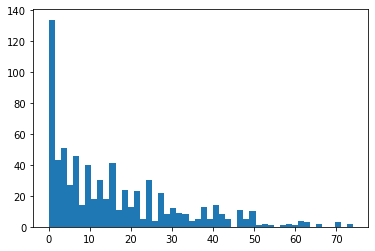

In [13]:
plt.hist(np.array([delivered[i][3]-delivered[i][0] for i in range(len(delivered))]), bins = 50)
plt.show()

(array([23., 18., 15., 20., 17., 12.,  7., 14., 12.,  8.,  5.,  5.,  4.,
         5.,  1.,  3.,  2.,  2.,  1.,  8.,  7., 20., 16., 25., 31., 24.,
        12., 19.,  4., 10.,  2.,  6.,  5., 13., 21., 20., 31., 21., 31.,
        21., 38., 16., 17., 11., 25., 14., 32., 13., 26., 20.]),
 array([  133.  ,  1279.02,  2425.04,  3571.06,  4717.08,  5863.1 ,
         7009.12,  8155.14,  9301.16, 10447.18, 11593.2 , 12739.22,
        13885.24, 15031.26, 16177.28, 17323.3 , 18469.32, 19615.34,
        20761.36, 21907.38, 23053.4 , 24199.42, 25345.44, 26491.46,
        27637.48, 28783.5 , 29929.52, 31075.54, 32221.56, 33367.58,
        34513.6 , 35659.62, 36805.64, 37951.66, 39097.68, 40243.7 ,
        41389.72, 42535.74, 43681.76, 44827.78, 45973.8 , 47119.82,
        48265.84, 49411.86, 50557.88, 51703.9 , 52849.92, 53995.94,
        55141.96, 56287.98, 57434.  ]),
 <a list of 50 Patch objects>)

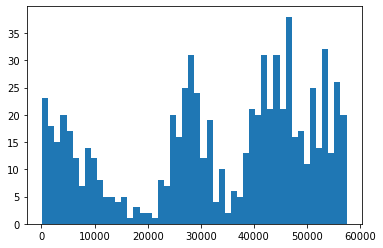

In [14]:
plt.hist(np.array(pass_array).T[0], bins = 50)